# What mineral is it?

An image classification model for identifying different types of minerals. In our case, we're differentiating between **quartz and amazonite**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import the fastai library

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/minerals/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['.ipynb_checkpoints', 'valid', 'models', 'train']

## We would be using Jeremy Howard's easy steps train a world-class image classifier

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

### But let's first take a look at the pictures

We are using 118 training images and 20 in the validation folder

**amazonite**

In [8]:
files = os.listdir(f'{PATH}valid/amazonite')[:5]

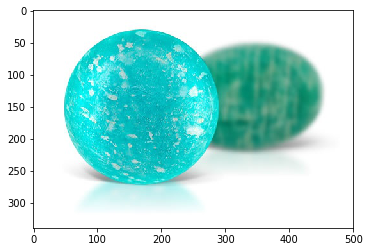

In [9]:
img = plt.imread(f'{PATH}valid/amazonite/{files[0]}')
plt.imshow(img);

**quartz**

In [10]:
files = os.listdir(f'{PATH}valid/quartz')[:5]

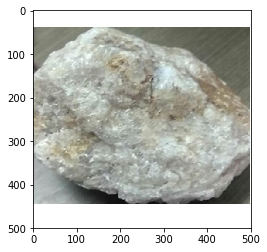

In [11]:
img = plt.imread(f'{PATH}valid/quartz/{files[0]}')
plt.imshow(img);

### On to the fun part!

1. precompute=True

In [12]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=4)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 10/10 [00:00<00:00, 32.38it/s]


2. Use `lr_find()` to find highest learning rate where loss is still clearly improving


In [13]:
lrf=learn.lr_find()

 61%|██████    | 36/59 [00:00<00:00, 121.40it/s, loss=9.15] 


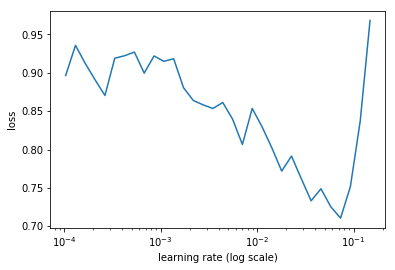

In [14]:
learn.sched.plot()

Based on the plot, I chose a learning rate of 1e-2.

As an aside the plot looks scary though

3. Train last layer from precomputed activations for 1-2 epochs


In [15]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.027694   0.576625   0.825     
    1      1.086868   0.623221   0.75                      



[array([0.62322]), 0.75]

We have an accuracy of 82.5%.

4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

Because we are dealing with pictures of minerals, we will use *transforms-top-down*

In [16]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [17]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [18]:
ims = np.stack([get_augs() for i in range(6)])

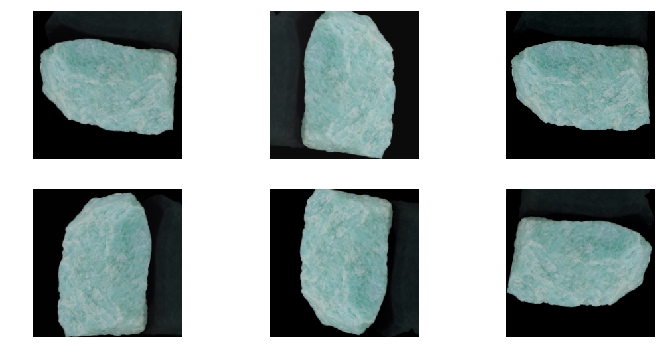

In [19]:
plots(ims, rows=2)

In [20]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [21]:
learn.precompute = False

In [22]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.681045   0.156651   0.95      
    1      0.722755   0.415984   0.8                       
    2      0.597746   0.24576    0.925                     



[array([0.24576]), 0.925]

With data augmentation we get a maximum accuracy of 95%

5. Unfreeze all layers

In [23]:
learn.unfreeze()

6. Set earlier layers to 3x-10x lower learning rate than next higher layer

In [27]:
lrs=np.array([1e-4,1e-3,1e-2])

7. Use `lr_find()` again

In [25]:
lrf = learn.lr_find()

 73%|███████▎  | 43/59 [00:03<00:01, 14.17it/s, loss=2.52] 


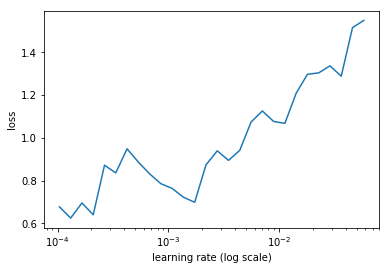

In [26]:
learn.sched.plot()

Well, that's a really weird plot
But it looks like a learning rate of 1e-3 would work better

In [45]:
lrs=np.array([1e-5,1e-4,1e-3])

8. Train full network with cycle_mult=2 until over-fitting

In [28]:
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.527101   0.15939    0.9       
    1      0.730885   0.243383   0.925                     
    2      0.538973   0.208737   0.875                     
    3      0.473103   0.156587   0.925                     
    4      0.598045   0.089324   0.95                      
    5      0.607477   0.079499   0.95                      
    6      0.453201   0.076239   0.975                     
    7      0.449327   0.108054   0.95                      
    8      0.423748   0.099585   0.975                     
    9      0.427165   0.1236     0.95                      
    10     0.436281   0.04008    1.0                       
    11     0.381006   0.057075   1.0                       
    12     0.401612   0.054928   1.0                       
    13     0.347775   0.065944   0.975                     
    14     0.402111   0.050648   1.0                       
    15     0.352285   0.049866   1.0                    

[array([0.08146]), 0.975]

## Our last coin... TTA

Let's use TTA to make predictions on the validation set

In [29]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [30]:
accuracy_np(probs, y)

0.975

## A look at the predictions

In [31]:
preds = np.argmax(probs, axis=1)  
probs = probs[:, 1]       

In [32]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [33]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [34]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [35]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


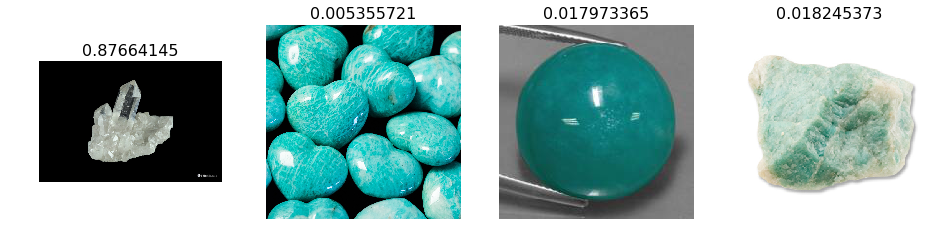

In [36]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [37]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct amazonites


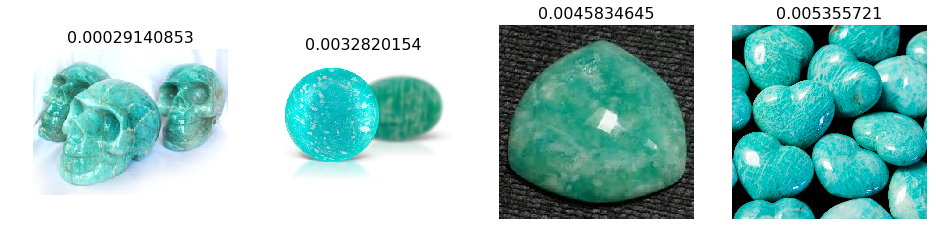

In [38]:
plot_val_with_title(most_by_correct(0, True), "Most correct amazonites")

Most correct quartz


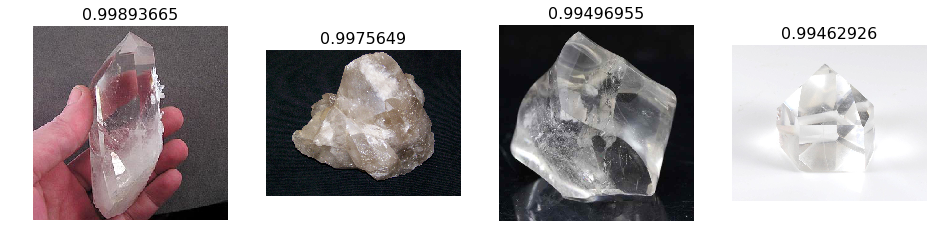

In [39]:
plot_val_with_title(most_by_correct(1, True), "Most correct quartz")

Most incorrect amazonites


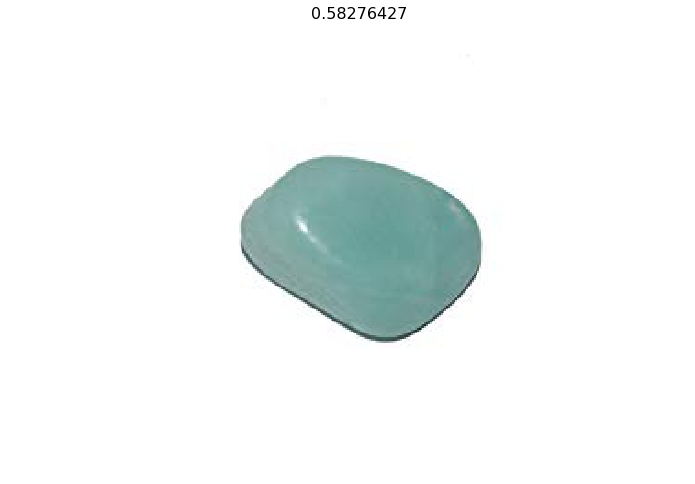

In [40]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect amazonites")

In [41]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most incorrect dogs


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


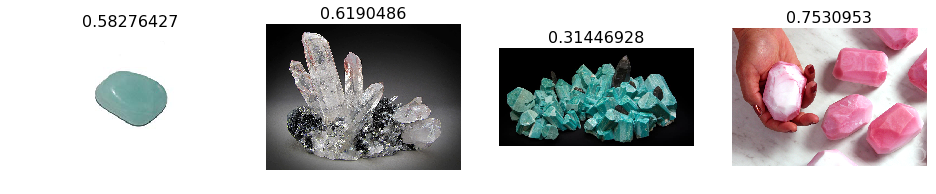

In [42]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Confusion matrix

Let's analyse what we've seen with a confusion matrix

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[19  1]
 [ 0 20]]


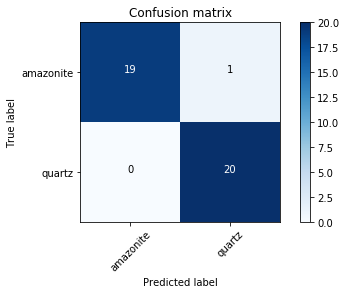

In [44]:
plot_confusion_matrix(cm, data.classes)

That really clears things up:
We only classified one image incorrectly which I think is good feat